In [183]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import as_strided
from torchvision.transforms import ToPILImage
from PIL import Image
from utils import mnist_reader
from sklearn.model_selection import train_test_split

class Dataset:
  def __init__(self, x, y, batch_size = 32):
    self.x = x
    self.y = y
    self.batch_size = batch_size
    self.length = int(np.ceil(x.shape[0]/batch_size))
    self.indices = np.arange(x.shape[0]) # 0, 1, 2, 3, 4, ..., n - 1

  def __getitem__(self, i): # i: 0, 1, 2, 3 ..., __len__
    i0 = i*self.batch_size
    i1 = min((i + 1)*self.batch_size, self.x.shape[0])
    index = self.indices[i0:i1]
    return self.x[index], self.y[index]

  def __len__(self):
    return self.length

  def shuffle(self):
    self.indices = np.random.permutation(self.indices)

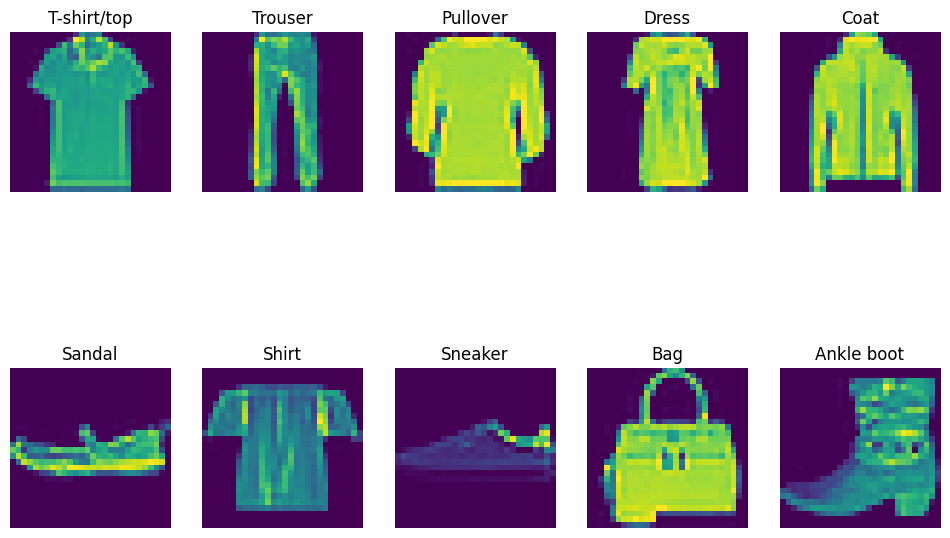

In [184]:
# Load Fashion-MNIST training data using utils.mnist_reader
train_images, train_labels = mnist_reader.load_mnist('data/fashion', kind='train')

# Normalize the training data to the range [0, 1]
train_images = train_images / 255.0

# Define the class labels for Fashion-MNIST
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Visualize one random sample from each class
plt.figure(figsize=(12, 8))
for i in range(10):
    # Filter samples for the current class
    class_samples = train_images[train_labels == i]

    # Randomly choose one sample from the current class
    random_index = np.random.randint(0, len(class_samples))
    random_sample = class_samples[random_index]

    # Reshape the sample to (28, 28) for plotting
    random_sample = np.reshape(random_sample, (28, 28))

    # Plot the sample
    plt.subplot(2, 5, i + 1)
    plt.imshow(random_sample, cmap='viridis')
    plt.title(class_labels[i])
    plt.axis('off')

plt.show()

Training set shape: torch.Size([48000, 1, 28, 28])
Training labels shape: torch.Size([48000])
Validation set shape: torch.Size([12000, 1, 28, 28])
Validation labels shape: torch.Size([12000])


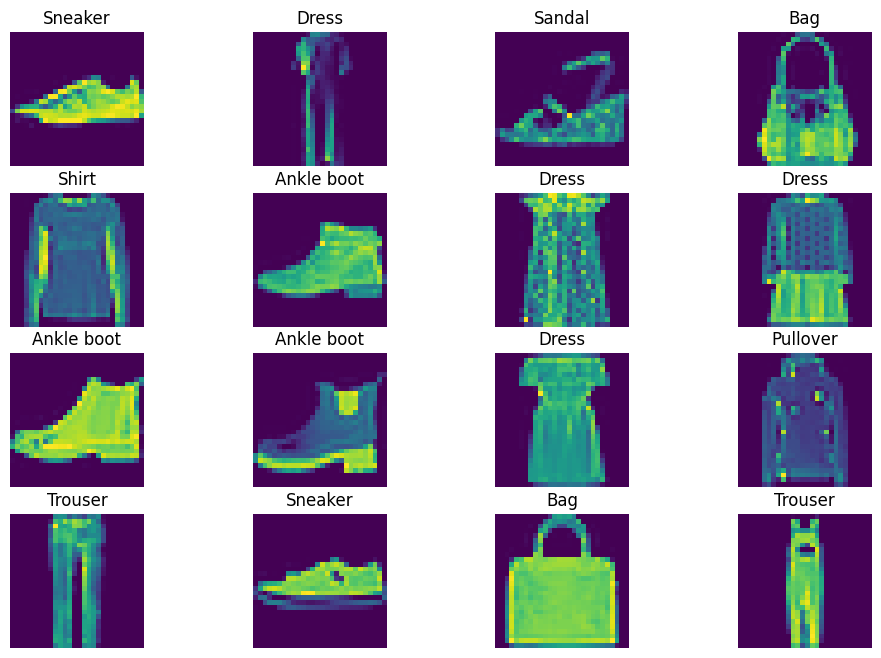

In [185]:
# Split the data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42
)

# Reshape the samples for both training and validation sets
train_images = train_images.reshape(-1, 1, 28, 28)
val_images = val_images.reshape(-1, 1, 28, 28)

# Convert NumPy arrays to PyTorch tensors
train_images = torch.Tensor(train_images)
train_labels = torch.LongTensor(train_labels)
val_images = torch.Tensor(val_images)
val_labels = torch.LongTensor(val_labels)

# Convert class labels to one-hot encodings
train_labels_onehot = torch.zeros(train_labels.size(0), 10)
train_labels_onehot.scatter_(1, train_labels.view(-1, 1), 1)
val_labels_onehot = torch.zeros(val_labels.size(0), 10)
val_labels_onehot.scatter_(1, val_labels.view(-1, 1), 1)

# Print the shapes of the subsets
print("Training set shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Validation set shape:", val_images.shape)
print("Validation labels shape:", val_labels.shape)

# Create custom datasets using the provided Dataset class
train_dataset = Dataset(train_images, train_labels_onehot)
val_dataset = Dataset(val_images, val_labels_onehot)

batch_samples, batch_labels = train_dataset[0]

num_figures = 16
# Visualize the samples and corresponding class labels
plt.figure(figsize=(12, 8))
for i in range(num_figures):
    plt.subplot(4, 4, i + 1)
    sample_image = batch_samples[i][0].numpy()  
    plt.imshow(sample_image, cmap='viridis')
    #plt.title(f"Class: {torch.argmax(batch_labels[i]).item()}")
    plt.title(class_labels[torch.argmax(batch_labels[i])])
    plt.axis('off')
plt.show()

In [186]:
class Conv2d(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size))
        self.bias = nn.Parameter(torch.zeros(out_channels))
        self.stride = stride

    def forward(self, x):
        batch_size, in_channels, height, width = x.size()
        out_channels, _, kernel_size, _ = self.weight.size()

        # Calculate output dimensions
        out_height = (height - kernel_size) // self.stride + 1
        out_width = (width - kernel_size) // self.stride + 1

        # Unfold the input tensor
        unfolded_x = nn.functional.unfold(x, kernel_size, stride=self.stride)

        # Reshape the unfolded tensor to match weight dimensions
        unfolded_x = unfolded_x.view(batch_size, in_channels, kernel_size * kernel_size, out_height * out_width).flatten(1,2)

        # Reshape the weight tensor to (out_channels, in_channels * kernel_size * kernel_size)
        weight_reshaped = self.weight.view(out_channels, -1)
        # Perform convolution using matrix multiplication
        output = torch.matmul(weight_reshaped, unfolded_x).view(batch_size, out_channels, out_height, out_width) + self.bias.unsqueeze(-1).unsqueeze(-1)

        return output


class MaxPool2d(torch.nn.Module):
    def __init__(self, kernel_size, stride):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride

    def forward(self, x):
        batch_size, channels, height, width = x.size()

        # Calculate output dimensions
        out_height = (height - self.kernel_size) // self.stride + 1
        out_width = (width - self.kernel_size) // self.stride + 1

        # Reshape the input tensor to make pooling efficient
        x_reshaped = x.unfold(2, self.kernel_size, self.stride).unfold(3, self.kernel_size, self.stride)

        # Reshape and permute to make pooling efficient
        x_reshaped = x_reshaped.contiguous().view(batch_size, channels, -1, self.kernel_size, self.kernel_size)

        # Take the maximum value along the last two dimensions
        pooled_values, _ = x_reshaped.max(dim=-1, keepdim=False)
        pooled_values, _ = pooled_values.max(dim=-1, keepdim=False)
        pooled_values = pooled_values.view(batch_size, channels, out_height, out_width)

        return pooled_values
class ReLU(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # ReLU activation without using torch.nn.functional.relu
        return torch.max(torch.zeros_like(x), x)


In [187]:
# Create instances of custom and torch.nn modules
custom_conv = Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1)
custom_conv2 = Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1)
torch_conv = torch.nn.Conv2d(in_channels=2, out_channels=32, kernel_size=3, stride=1)

custom_maxpool = MaxPool2d(kernel_size=3, stride=2)
torch_maxpool = torch.nn.MaxPool2d(kernel_size=3, stride=2)

custom_relu = ReLU()
torch_relu = torch.nn.ReLU()

# Generate random input tensor
input_tensor = torch.randn(32, 1, 28, 28)
input_tensor2 = torch.randn(32, 3, 28, 28)
res1 = custom_conv(input_tensor)
res = custom_conv2(input_tensor2)
# Test Conv2d
# Copy weight and bias from custom implementation to torch.nn implementation
torch_conv.weight.data = custom_conv.weight
torch_conv.bias.data = custom_conv.bias
torch_conv_output = torch_conv(input_tensor)
custom_conv_output = custom_conv(input_tensor)
conv_diff = torch.abs(custom_conv_output - torch_conv_output).max().item()
print(conv_diff)

# Test MaxPool2d
torch_maxpool_output = torch_maxpool(torch_conv_output)
print(torch_maxpool_output.shape)
custom_maxpool_output = custom_maxpool(custom_conv_output)
print(custom_maxpool_output.shape)
maxpool_diff = torch.abs(custom_maxpool_output - torch_maxpool_output).max().item()
print(maxpool_diff)

# Test ReLU
custom_relu_output = custom_relu(custom_maxpool_output)
torch_relu_output = torch_relu(torch_maxpool_output)
relu_diff = torch.abs(custom_relu_output - torch_relu_output).max().item()
print(relu_diff)

# Check if maximal difference is smaller than 1e-5
if conv_diff < 1e-5 and maxpool_diff < 1e-5 and relu_diff < 1e-5:
    print("Custom implementations match torch.nn implementations.")
else:
    print("There is a mismatch between custom and torch.nn implementations.")

9.5367431640625e-07
torch.Size([32, 32, 12, 12])
torch.Size([32, 32, 12, 12])
0.0
0.0
Custom implementations match torch.nn implementations.


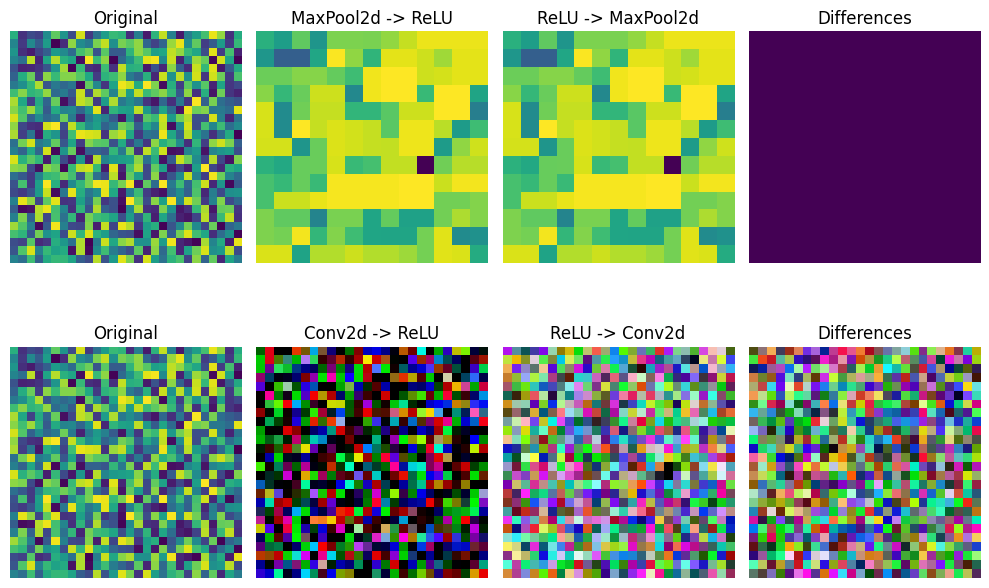

The outputs of the two sets are the same. This means that the MaxPool and ReLU operations commute in this case. 
That is because if we apply maxpooling first and ReLU second, we keep the largest values from which we then turn the negative values to 0.
If we do it the other way around, we first turn the negative values to 0 and then keep the largest values.
Since the largest values will always be either 0 or more in either case, the operation order doesn't matter.
When performing the convolution, however, the order matters as it is a more complex operation and does not commute with ReLU.


In [188]:
# Define the random input tensor
input_tensor = torch.rand(1, 1, 28, 28) * 2 - 1  # Random elements in the range [-1, 1]
# Define the transformations
maxpool_relu_transform = torch.nn.Sequential(
    MaxPool2d(kernel_size=3, stride=2),
    ReLU()
)

relu_maxpool_transform = torch.nn.Sequential(
    ReLU(),
    MaxPool2d(kernel_size=3, stride=2)
)

conv_relu_transform = torch.nn.Sequential(
    Conv2d(in_channels=1, out_channels=3, kernel_size=3, stride=1),
    ReLU()
)

relu_conv_transform = torch.nn.Sequential(
    ReLU(),
    Conv2d(in_channels=1, out_channels=3, kernel_size=3, stride=1)
)
# Apply the transformations
output_maxpool_relu = maxpool_relu_transform(input_tensor)  # Add batch and channel dimensions
output_relu_maxpool = relu_maxpool_transform(input_tensor)
output_conv_relu = conv_relu_transform(input_tensor)
output_relu_conv = relu_conv_transform(input_tensor)


# Convert tensors to images for visualization
to_pil = ToPILImage()
original = to_pil(input_tensor.squeeze())
image_maxpool_relu = to_pil(output_maxpool_relu.squeeze())
image_relu_maxpool = to_pil(output_relu_maxpool.squeeze())
diff = to_pil(torch.abs(output_maxpool_relu - output_relu_maxpool).squeeze())

image_conv_relu = to_pil(output_conv_relu.squeeze())
image_relu_conv = to_pil(output_relu_conv.squeeze())
diff2 = to_pil(torch.abs(output_conv_relu - output_relu_conv).squeeze())
# Display the original and transformed images
plt.figure(figsize=(10, 7))

plt.subplot(2, 4, 1)
plt.imshow(original)
plt.title('Original')
plt.axis('off')

plt.subplot(2, 4, 2)
plt.imshow(image_maxpool_relu)
plt.title('MaxPool2d -> ReLU')
plt.axis('off')

plt.subplot(2, 4, 3)
plt.imshow(image_relu_maxpool)
plt.title('ReLU -> MaxPool2d')
plt.axis('off')

plt.subplot(2, 4, 4)
plt.imshow(diff)
plt.title('Differences')
plt.axis('off')


plt.subplot(2, 4, 5)
plt.imshow(original)
plt.title('Original')
plt.axis('off')

plt.subplot(2, 4, 6)
plt.imshow(image_conv_relu)
plt.title('Conv2d -> ReLU')
plt.axis('off')

plt.subplot(2, 4, 7)
plt.imshow(image_relu_conv)
plt.title('ReLU -> Conv2d')
plt.axis('off')

plt.subplot(2, 4, 8)
plt.imshow(diff2)
plt.title('Differences')
plt.axis('off')
plt.tight_layout()

plt.show()
print("""The outputs of the two sets are the same. This means that the MaxPool and ReLU operations commute in this case. 
That is because if we apply maxpooling first and ReLU second, we keep the largest values from which we then turn the negative values to 0.
If we do it the other way around, we first turn the negative values to 0 and then keep the largest values.
Since the largest values will always be either 0 or more in either case, the operation order doesn't matter.
When performing the convolution, however, the order matters as it is a more complex operation and does not commute with ReLU.""")

In [189]:
class CustomConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.operations = nn.Sequential(
            # First convolution block
            Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1),
            MaxPool2d(kernel_size=3, stride=2),
            ReLU(),

            Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            MaxPool2d(kernel_size=3, stride=2),
            ReLU(),

            Conv2d(in_channels=64, out_channels=10, kernel_size=4, stride=1),
            nn.Flatten()
        )

    def forward(self, x):
        return self.operations(x)

# Create an instance of the custom network
custom_model = CustomConvNet()

class TorchConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.operations = nn.Sequential(
            # First convolution block
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=4, stride=1),
            nn.Flatten()
        )

    def forward(self, x):
        return self.operations(x)

# Create an instance of the PyTorch built-in network
torch_model = TorchConvNet()

In [190]:
def fit(model, number_of_epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    best_model = None
    best_val_loss = float('inf')
    training_losses = []
    validation_losses = []

    for epoch in range(number_of_epochs):
        print(f"Epoch: {epoch}")
        model.train()
        running_train_loss = 0.0

        for i in range(len(train_dataset)):
            inputs, labels = train_dataset[i]
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        average_train_loss = running_train_loss / len(train_dataset)
        training_losses.append(average_train_loss)

        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            for i in range(len(val_dataset)):
                inputs, labels = val_dataset[i]
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

        average_val_loss = running_val_loss / len(val_dataset)
        validation_losses.append(average_val_loss)

        # Check for the best model
        if average_val_loss < best_val_loss:
            best_val_loss = average_val_loss
            best_model = model.state_dict()


    # Load the best model parameters
    model.load_state_dict(best_model)

    return model, training_losses, validation_losses

# Assuming you have training and validation data loaders for both models
# train_loader_custom, val_loader_custom, train_loader_torch, val_loader_torch

# Train the custom model
print("Treniramo našega")
best_custom_model, training_losses_custom, validation_losses_custom = fit(custom_model, 10)

# Train the PyTorch equivalent model
print("Treniramo torchovega")
best_torch_model, training_losses_torch, validation_losses_torch = fit(torch_model, 10)


Treniramo našega
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Treniramo torchovega
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9


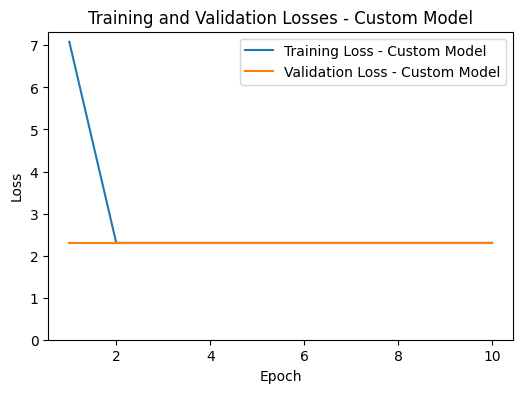

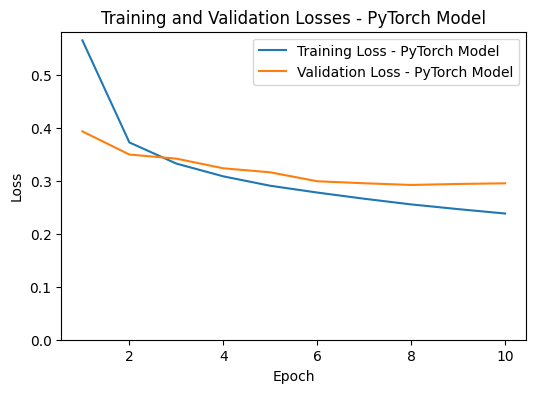


As seen from the pictures, there is a difference in performance between my custom model and torch's model.
The first and most important factor is probably the weight and bias initialization as PyTorch might use a more sophisticated and optimized weight initialization.
The second could be numerical stability as PyTorch's layers might handle it more efficiently and thus affect the results.



In [195]:
def plot_losses(training_losses, validation_losses, model_name):
    epochs = range(1, len(training_losses) + 1)

    plt.figure(figsize=(6, 4))
    plt.plot(epochs, training_losses, label=f'Training Loss - {model_name}')
    plt.plot(epochs, validation_losses, label=f'Validation Loss - {model_name}')
    plt.ylim(bottom=0)

    plt.title(f'Training and Validation Losses - {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Assuming you have the training_losses and validation_losses for both models
# training_losses_custom, validation_losses_custom, training_losses_torch, validation_losses_torch

plot_losses(training_losses_custom, validation_losses_custom, 'Custom Model')
plot_losses(training_losses_torch, validation_losses_torch, 'PyTorch Model')
print("""
As seen from the pictures, there is a difference in performance between my custom model and torch's model.
The first and most important factor is probably the weight and bias initialization as PyTorch might use a more sophisticated and optimized weight initialization.
The second could be numerical stability as PyTorch's layers might handle it more efficiently and thus affect the results.
""")